<a href="https://colab.research.google.com/github/mraslann/Image-cartoonification-and-road-lane-detection/blob/main/Image_cartoonifying_and_detecting_road_lanes_with_Hough_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1

In [ ]:
import zipfile
import tensorflow as tf
tf.test.gpu_device_name()
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import math
from copy import deepcopy

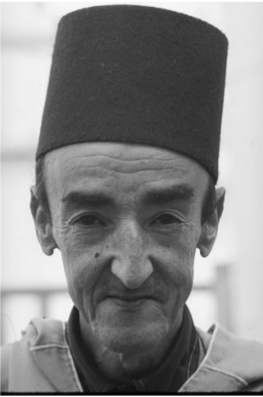

In [ ]:
image = cv2.imread('original rgb.png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(image)

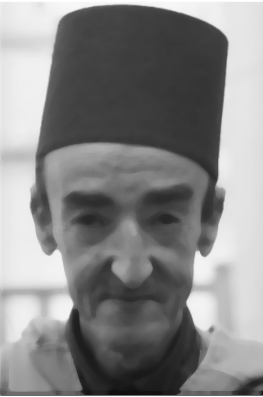

In [ ]:
median = cv2.medianBlur(image, 7)
cv2_imshow(median)

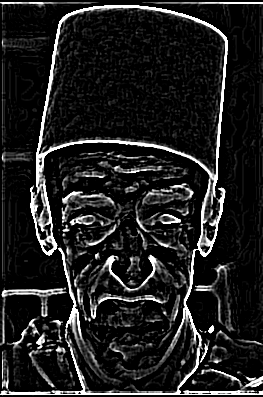

In [ ]:
laplace = cv2.Laplacian(median, 16, ksize=5)
cv2_imshow(laplace)

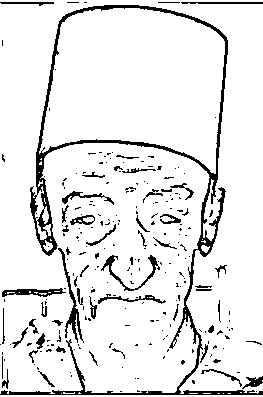

In [ ]:
ret, thresh1 = cv2.threshold(laplace, 120, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(thresh1)

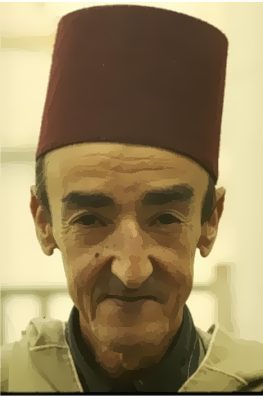

In [ ]:
bilateral = cv2.imread('original rgb.png')
for _ in range(7):
        bilateral = cv2.bilateralFilter(bilateral, 9, 9, 7)
cv2_imshow(bilateral)


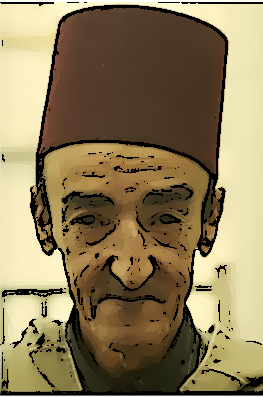

In [ ]:
finalimage = cv2.bitwise_and(bilateral, bilateral, mask=thresh1)
cv2_imshow(finalimage)

# Part 2

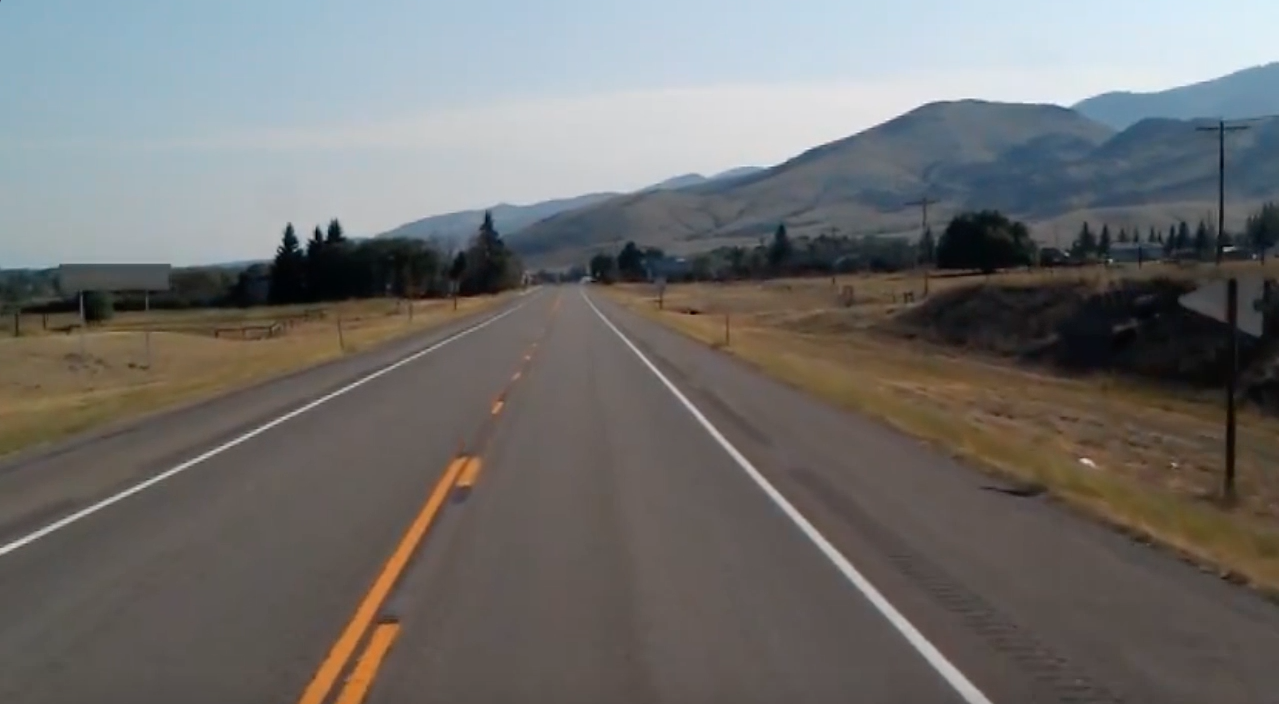

In [ ]:
image = cv2.imread('testHough.jpg')
cv2_imshow(image)

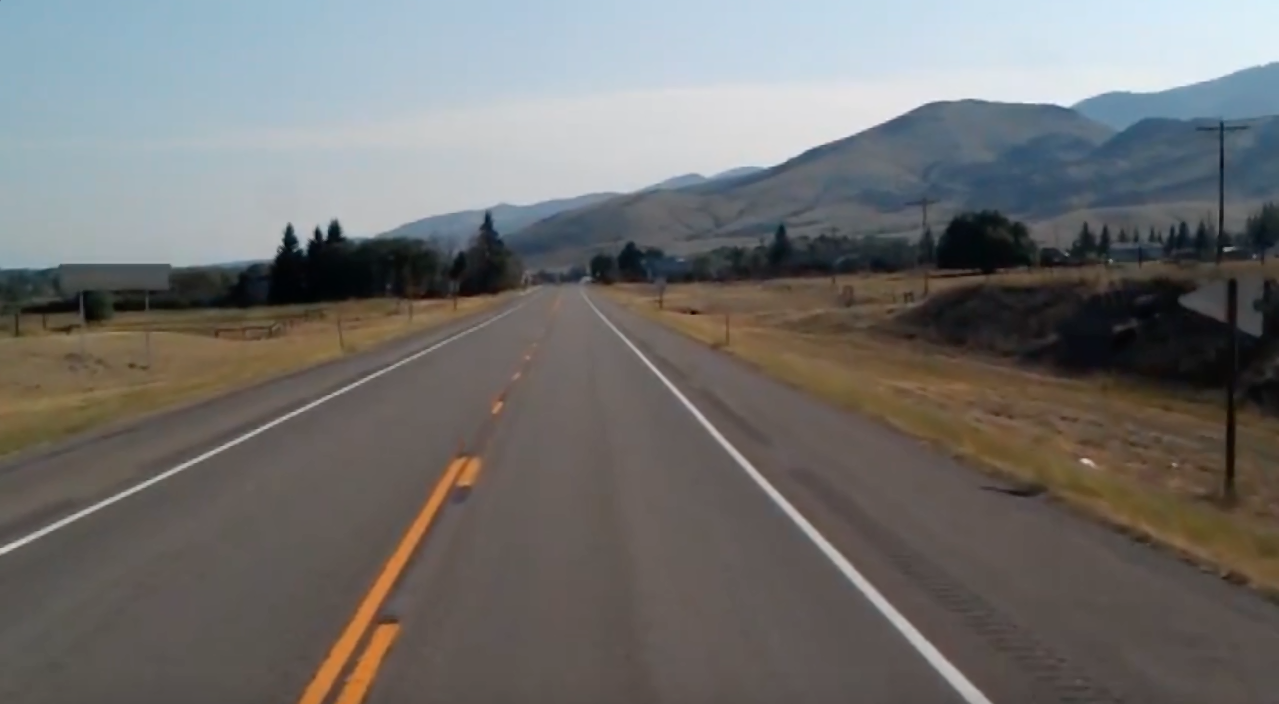

In [ ]:
median_image = cv2.medianBlur(image,3)
cv2_imshow(median_image)

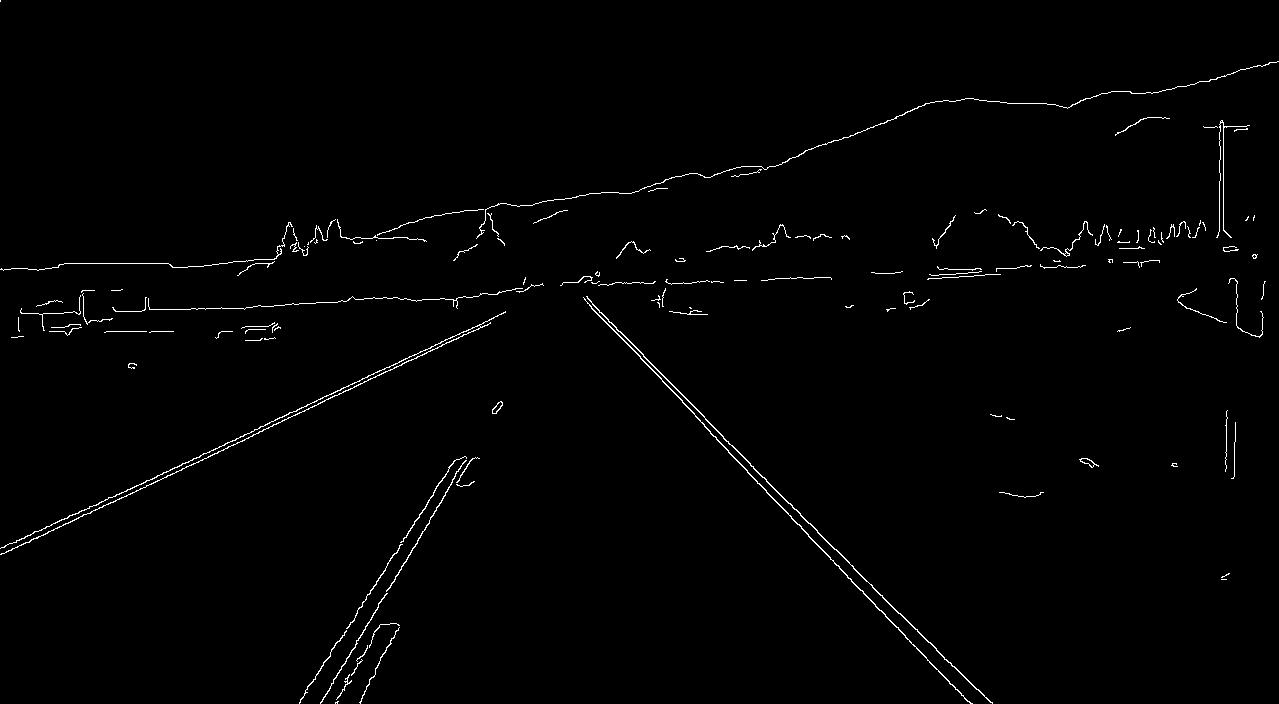

In [ ]:
canny = cv2.Canny(median_image,90,150)
cv2_imshow(canny)

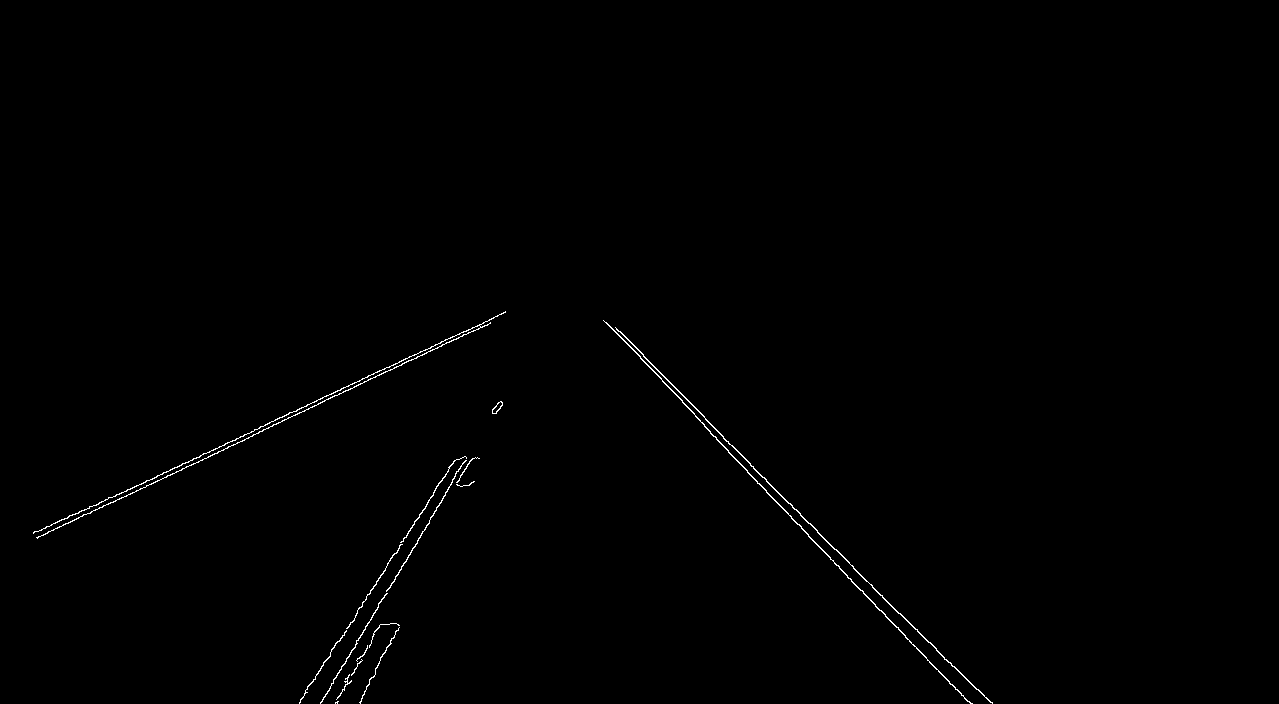

In [ ]:
def region_of_interest(image):
  height = image.shape[0]
  polygons = np.array([
  [(200, height), (1270, height), (550, 290), (0, 500)]
  ])
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, polygons, 255)
  masked_image = cv2.bitwise_and(image, mask)
  return masked_image
cropped_image = region_of_interest(canny)
cv2_imshow(cropped_image)

In [ ]:
def houghLine(image):
  Ny = image.shape[0]
  Nx = image.shape[1]
  Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))
  thetas = np.deg2rad(np.arange(-90, 90))
  rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
  accumulator = np.zeros((len(rs), len(thetas)))
  for y in range(Ny):
    for x in range(Nx):
      if image[y,x] > 0:
        for k in range(len(thetas)):
          r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
          accumulator[int(r) + Maxdist,k] += 1
  return accumulator, thetas, rs

In [ ]:
accumulator_arr, thetas, rhos = houghLine(cropped_image)

In [ ]:
indices = []
rho = int(np.round(math.sqrt(cropped_image.shape[0]**2 + cropped_image.shape[1]**2)))
rhos = np.arange(-rho, rho+1, 1)
thetas = np.deg2rad(np.arange(-90, 90, 1))
for i in range(10):
  idx = accumulator_arr.argmax()
  index = np.unravel_index(idx, accumulator_arr.shape)
  indices.append(index)
  accumulator_arr[index]=0

In [ ]:
print(len(indices))

10


In [ ]:
def draw_hough_lines(img, indices, rhos, thetas):
  for i in range(len(indices)):
    rho = rhos[indices[i][0]]
    theta = thetas[indices[i][1]]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0+1200*(-b))
    y1 = int(y0+1200*a)
    x2 = int(x0-1200*(-b))
    y2 = int(y0-1200*a)
    cv2.line(img, (x1,y1), (x2,y2), (0,0,255), 2)
  return img

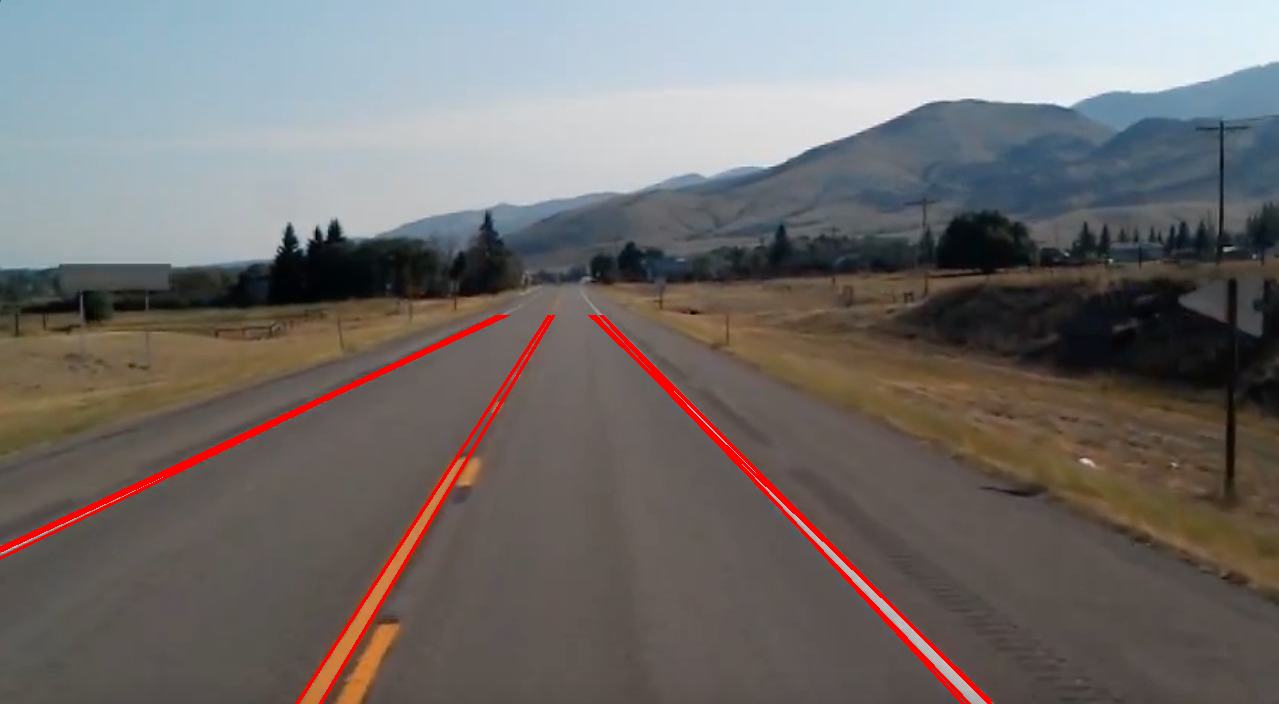

In [ ]:
copy_image = deepcopy(image)
copy_image = draw_hough_lines(copy_image, indices, rhos, thetas)
copy_image[:315, :, :] = image[:315, :, :]
cv2_imshow(copy_image)